# 1,2.Downloading the dataset and, generating data matrix and label vector

In [2]:
#---------------------
#importing libraries
#---------------------

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2 as cv
import glob
from sklearn import metrics

In [3]:
#-----------------------
#connecting to the drive
#-----------------------

# path = './archive/s*'



from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/pattern/FaceRecognition/archive/s*"

Mounted at /content/drive


In [4]:
#------------------------------------
# getting images of the 40 subjects
#------------------------------------

def get_face_data():
  label = []
  images = []
  d_shape = (1, 10304)
  data = np.empty(d_shape)
  i=0
  for dir in glob.glob(path):
    i = i + 1
    for img in glob.glob(dir + "/*.pgm"):
      image = cv.imread(img,0)
      #row, col = image.shape
      images.append(image)
      image = np.reshape(image,(1,10304))
      data = np.append(data, image, axis = 0)
      label.append(i)

  data = np.delete(data, (0), axis=0)

  #print(data.shape)
  y = np.array(label)
  #print(y.shape)
  #print(y)
  return data, y, images

data,y,images = get_face_data()    
print(data.shape)
print(y.shape)

(400, 10304)
(400,)


# 3. Split the data set into into training and test sets

In [5]:
#--------------
#training set ( odd rows )
#----------------
x_training = data[1::2,:]
y_training = y[1::2] 

#--------------
#test set ( even rows )
#----------------
x_testing = data[::2,:]
y_testing = y[::2]

print(x_training.shape)
print(x_testing.shape)
print(y_training.shape)
print(y_testing.shape)

(200, 10304)
(200, 10304)
(200,)
(200,)


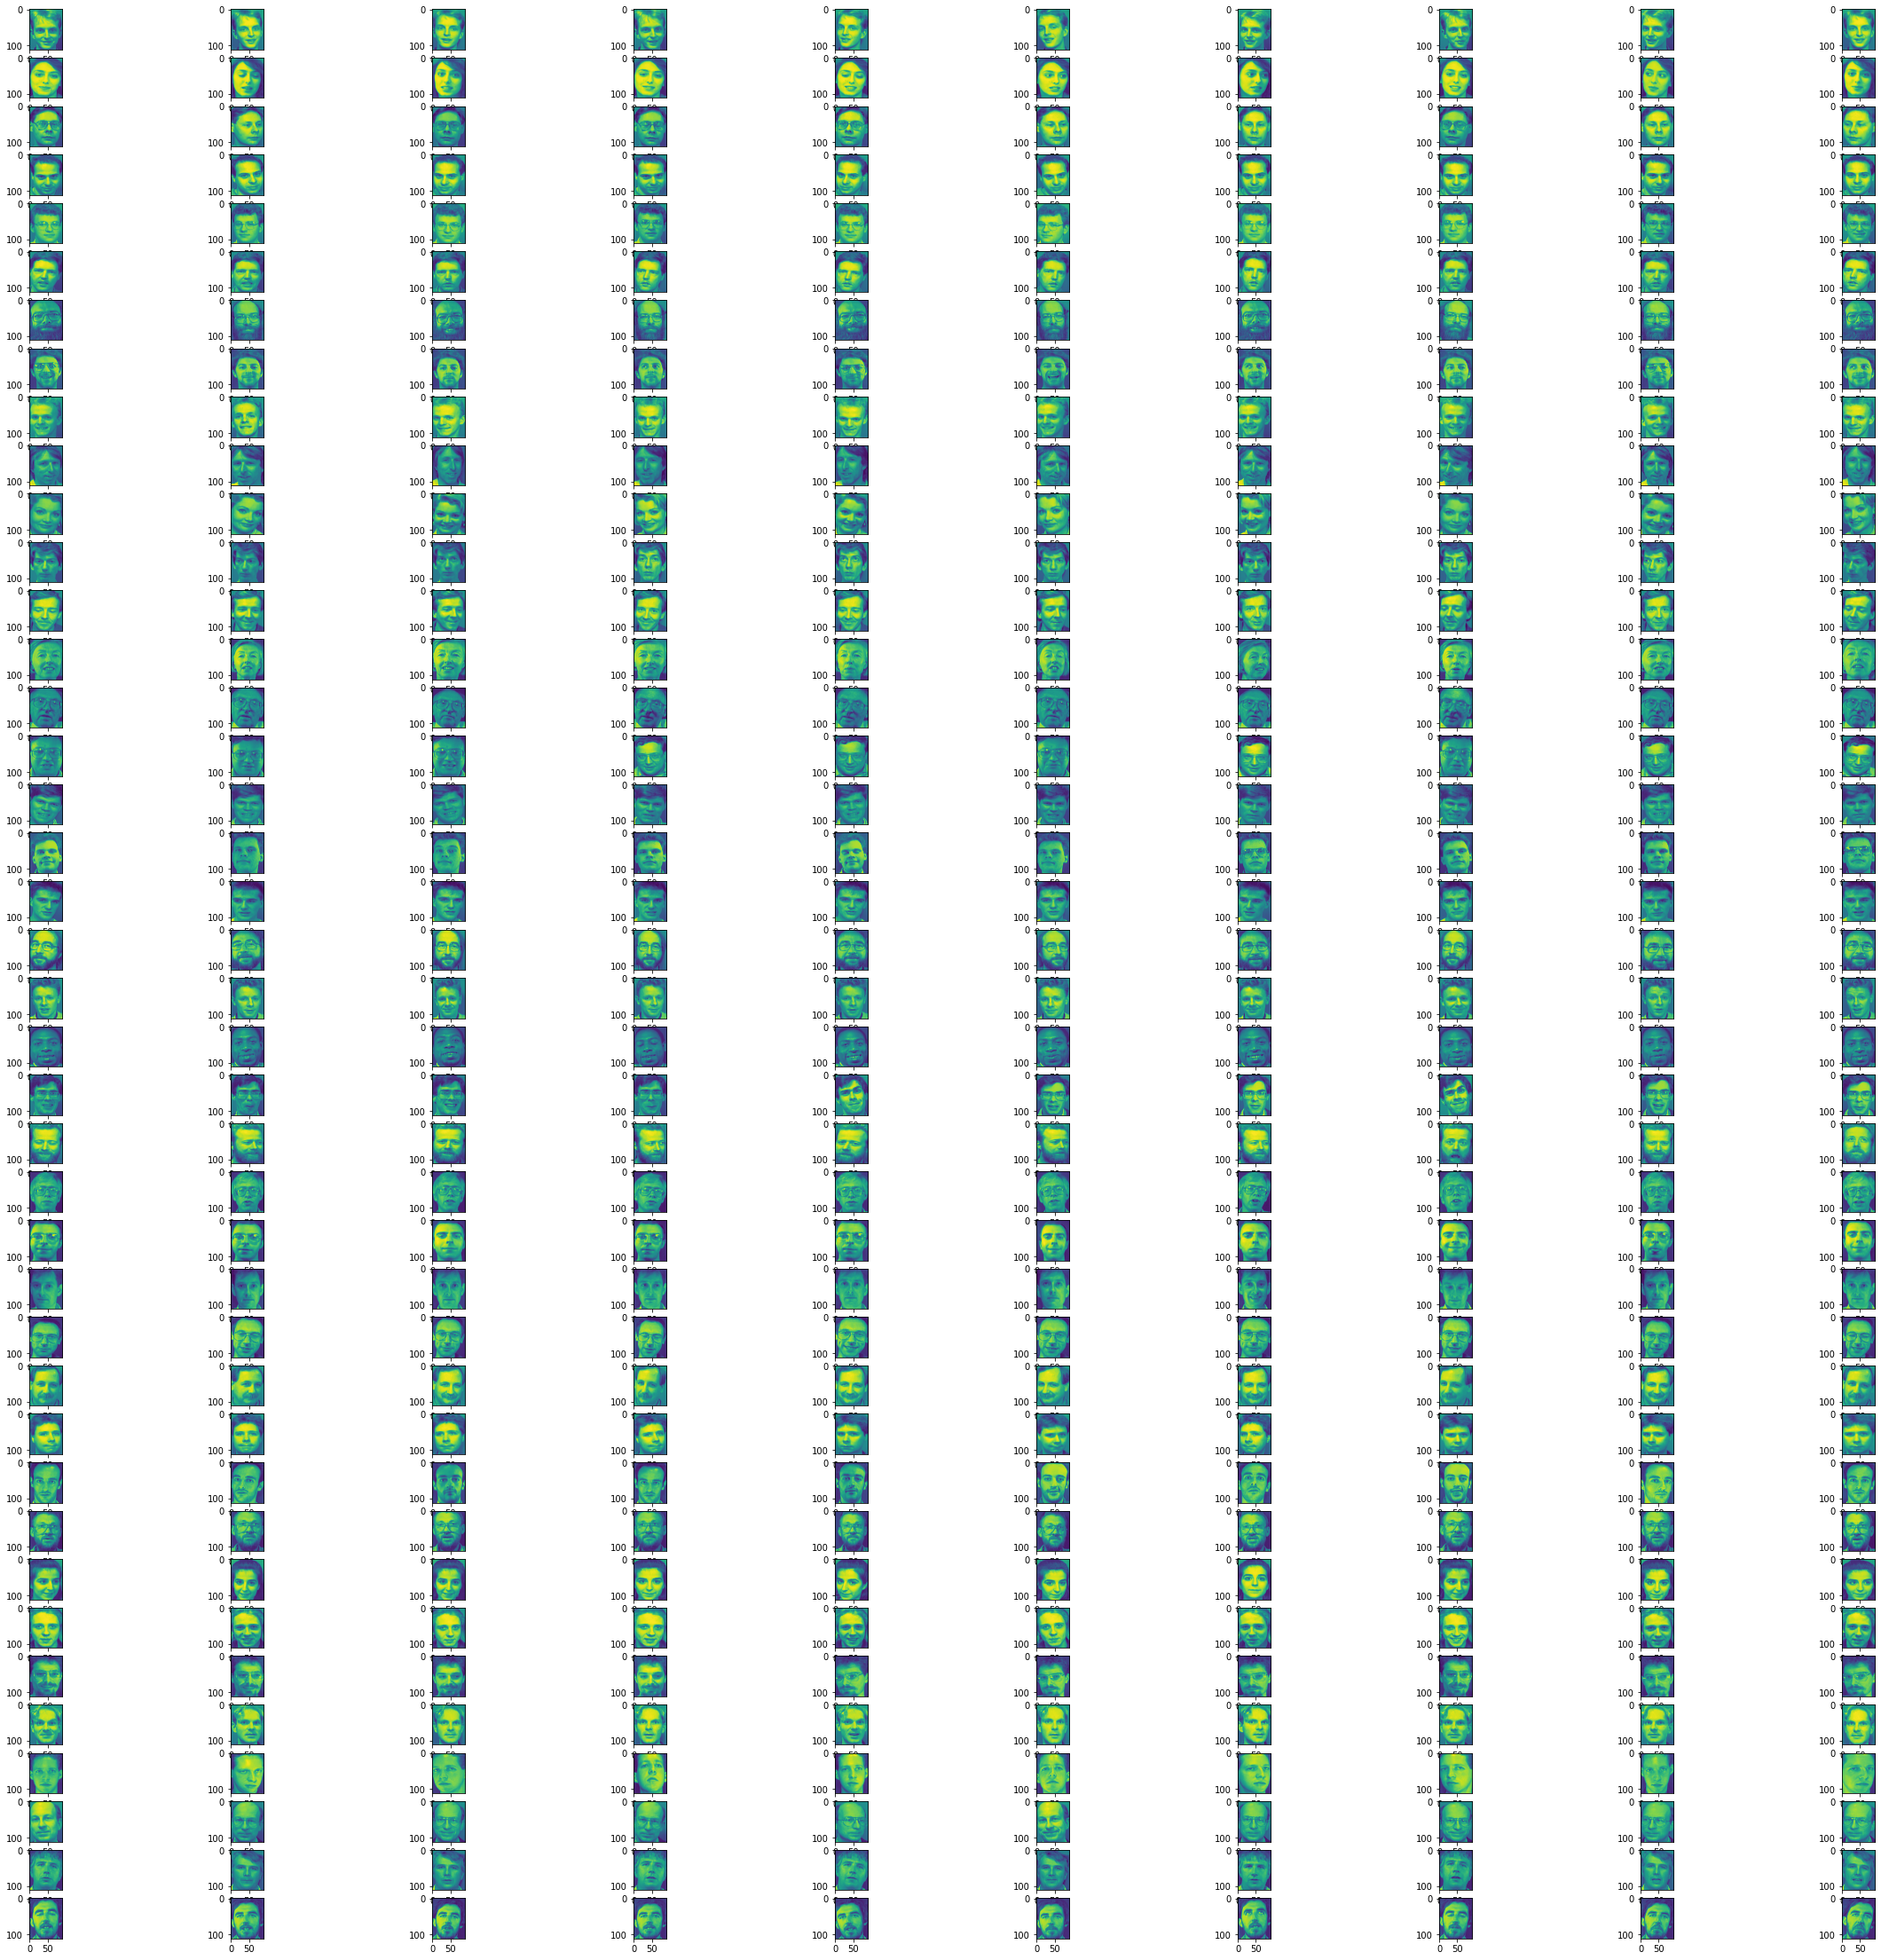

In [ ]:
#----------------
#plotting image for each subject 
#------------------
def plot(images):
  fig, ax = plt.subplots(40, 10, figsize=(40,40))
  for i in range(40):
    for j in range(10):
      ax[i][j].imshow(images[i*10+j])
  plt.show

plot(images)

# 4. Classification using PCA

a. Use the pseudo code below for computing the projection matrix U.
Define the alpha = {0.8,0.85,0.9,0.95}

In [ ]:
def pca(x_training, alphas):
  shape = []
  # computing mean
  mean = np.mean(x_training, axis=0)
  #print(mean)

  # computing the centered data matrix 'Z'
  Z = x_training - mean
  #print(Z)

  # computing the covariance matrix
  cov_matrix = np.cov(Z.transpose(), bias=True)

  # computing eigenvectors & their corresponding eigenvalue
  eval, evec = np.linalg.eigh(cov_matrix)

  # sorting eigenvectors according to the descending order of their corresponding eigenvalues
  idx = eval.argsort()[::-1]   
  eigenValues = eval[idx]
  eigenVectors = evec[:,idx]

#   print(eigenValues)
#   print(eigenVectors)

  # computing the sum of eigenvalues(denominator of the explained variance)
  sum_of_eigenValues = np.sum(eigenValues)

  # Us is a list of all the projection matrices generated by different values of alpha
  Us = [] 
  # looping on all values of alpha to calculate the projection matrices
  for alpha in alphas:
    sum_of_chosen_eigenValues = 0
    index = 0
    while (index < len(eigenValues)-1):
     # adding eigenvalues to the nominator of the explained variance until the explained variance reaches alpha
     if(sum_of_chosen_eigenValues/sum_of_eigenValues < alpha):
       sum_of_chosen_eigenValues = sum_of_chosen_eigenValues + eigenValues[index]
       index = index + 1
     else:
       break
    # U is a projection matrix
    U = eigenVectors[:, :index]
    shape.append(np.shape(U))
    # appending the latest projection matrix to the list of all the projection matrices
    Us.append(U)
  return Us, U, shape

In [ ]:
alphas = [0.8, 0.85, 0.9, 0.95]
Us, U, shape = pca (x_training, alphas)
print ( shape)

[86.18  86.38  86.75  ... 79.56  76.715 76.11 ]
[[ 44.82   38.62   39.25  ...   9.44   16.285  14.89 ]
 [ 38.82   32.62   37.25  ... -43.56  -37.715 -36.11 ]
 [ 32.82   33.62   33.25  ...   9.44   17.285   8.89 ]
 ...
 [-41.18  -37.38  -39.75  ... -39.56  -46.715 -32.11 ]
 [-36.18  -40.38  -37.75  ... -46.56  -43.715 -35.11 ]
 [-39.18  -37.38  -40.75  ... -48.56  -44.715 -42.11 ]]
[ 2.95300533e+06  2.06557474e+06  1.14590652e+06 ... -1.18021725e-09
 -1.48240992e-09 -1.96262702e-09]
[[ 1.78441119e-03 -1.31337163e-02 -1.87901573e-02 ...  0.00000000e+00
   0.00000000e+00  9.00500457e-28]
 [ 1.79916896e-03 -1.30293334e-02 -1.85585655e-02 ...  3.27966756e-01
  -8.87393688e-02  5.13687572e-02]
 [ 1.92668960e-03 -1.29253052e-02 -1.84782792e-02 ... -1.26492649e-01
   5.57775526e-01  1.97224728e-01]
 ...
 [ 6.20139643e-03  1.37837568e-02 -1.60728128e-02 ...  2.92567605e-02
   1.07019272e-02 -5.26262103e-03]
 [ 4.68527748e-03  1.13959977e-02 -1.59791007e-02 ...  8.71155043e-03
  -1.63389718e-02 

b. Project the training set, and test sets separately using the same
projection matrix.

c. Use a simple classifier (first Nearest Neighbor to determine the class
labels).

d. Report Accuracy for every value of alpha separately.

In [ ]:
# k nearest neighbor algorithm
from sklearn.neighbors import KNeighborsClassifier
def KNN_classifier(xtrain,ytrain,xtest,ytest,neighbours):
  knn = KNeighborsClassifier(n_neighbors=neighbours)
  knn.fit(xtrain, ytrain)
  accuracy = knn.score(xtest,ytest)
  ypredict = knn.predict(xtest)
  return accuracy,ypredict

In [ ]:
# printing the original accuracy before projection
accuracy, y_predict = KNN_classifier(x_training,y_training,x_testing,y_testing,1)
print("original accuracy before projection:",accuracy)

original accuracy before projection: 0.96


In [ ]:
i = 0
accuracies = []
x_training_new = []
x_testing_new = []

# looping on all values of alpha to project the data on the corresponding projection matrix and calculate the accuracy
for alpha in alphas:
    # projecting the training set
    x_training_new.append(np.dot(x_training, Us[i]))
    print(x_training_new[i].shape)
    # projecting the test set
    x_testing_new.append(np.dot(x_testing, Us[i]))
    print(x_testing_new[i].shape)
    # calculating accuracy
    accuracy , y_predict = KNN_classifier(x_training_new[i],y_training,x_testing_new[i],y_testing,1)
    accuracies.append(accuracy)
    i = i + 1
print(accuracies)


(200, 35)
(200, 35)
(200, 51)
(200, 51)
(200, 75)
(200, 75)
(200, 115)
(200, 115)
[0.94, 0.945, 0.95, 0.955]


Text(0, 0.5, 'accuracy')

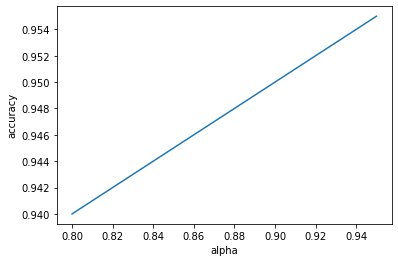

In [ ]:
# plotting each alpha against its accuracy
plt.plot(alphas, accuracies)
plt.xlabel('alpha')
plt.ylabel('accuracy')

**Observation** accuracy increases by increasing alpha

# PCA tuning

### Plotting with different values of K (neighbours)

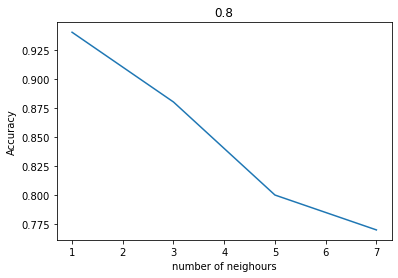

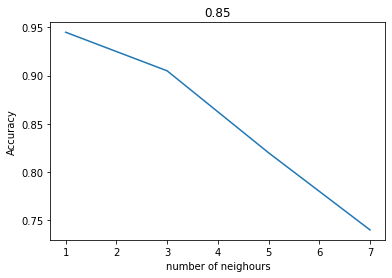

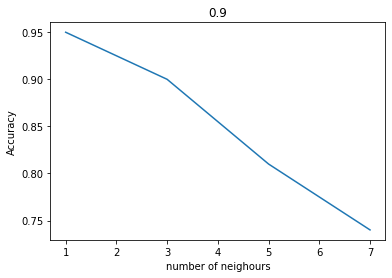

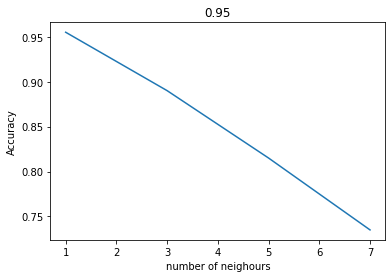

In [ ]:
i = 0
for alpha in alphas:
  accuracies = []
  kvalues = [1,3,5,7]
  for k in kvalues:
    accuracy = KNN_classifier(x_training_new[i],y_training,x_testing_new[i],y_testing,k)
    accuracies.append(accuracy) 
  plt.plot(np.array(kvalues),np.array(accuracies))
  plt.title(alpha)
  plt.xlabel("number of neighours")
  plt.ylabel("Accuracy")
  plt.show()
  i = i + 1

### PCA variant : randomized PCA (bonus)

Randomized PCA: 
This is an extension to PCA which uses approximated Singular Value Decomposition(SVD) of data. Conventional PCA works in O(n*p2) + O(p3) where n is the number of data points and p is the number of features whereas randomized version works in O(n*d*2) + O(d3) where d is the number of principal components. Thus, it is blazing fast when d is much smaller than n. 
sklearn provides a method randomized_svd in sklearn.utils.extmath which can be used to do randomized PCA. This method returns three matrices: U which is an m x m matrix, Sigma is an m x n diagonal matrix, and V^T is the transpose of an n x n matrix where T is a superscript. Another way to use sklearn.decomposition.PCA and change the svd_solver hyperparameter from ‘auto’ to ‘randomized’ or ‘full’. However, Scikit-learn automatically uses randomized PCA if either p or n exceeds 500 or the number of principal components is less than 80% of p and n. 

Randomized PCA is a variation of Principal Component Analysis (PCA) that is designed to approximate the first k principal components of a large dataset efficiently. Instead of computing the eigenvectors of the covariance matrix of the data, as is done in traditional PCA, randomized PCA uses a random projection matrix to map the data to a lower-dimensional subspace. The first k principal components of the data can then be approximated by computing the eigenvectors of the covariance matrix of the projected data.

Randomized PCA has several advantages over traditional PCA:

Scalability: Randomized PCA can handle large datasets that are not possible to fit into memory using traditional PCA.
Speed: Randomized PCA is much faster than traditional PCA for large datasets, making it more suitable for real-time applications.
Sparsity: Randomized PCA is able to handle sparse datasets, which traditional PCA is not able to handle well.
Low-rank approximation: Randomized PCA can be used to obtain a low-rank approximation of a large dataset, which can then be used for further analysis or visualization.

In [ ]:
from sklearn.decomposition import PCA

rnd_pca = PCA( n_components= 35, svd_solver='randomized')
X_train_variant = rnd_pca.fit(x_training, y_training)
X_train_variant = rnd_pca.transform(x_training)
X_test_variant = rnd_pca.transform(x_testing)           
          
#print(X_new_variant.shape)

In [ ]:
accuracy, ypredict = KNN_classifier(X_train_variant ,y_training,X_test_variant,y_testing,1)
print('Accuracy after randomized PCA = ', accuracy )


Accuracy after randomized PCA =  0.94


# 5. Classification using LDA

In [ ]:
def LDA(x,nc):
  #Calculating man vector for each class, where each class has 5 instances and 10304 dimensions
  N = x.shape[1]
  print(N)
  nk = x.shape[0]//nc
  means = []
  for i in range(nc):
    instances = x[i*nk:i*nk+nk]
    cmean = np.mean(instances,axis = 0).reshape(1,N)
    means.append(cmean)
  means = np.array(means).reshape(nc,N)
#   print("means:")
#   print(means)

  #------------------------------------------------------------------
  #Calculating between class scatter matrix
  total_mean = np.mean(x, axis = 0).reshape(1,10304)
  Sb = np.zeros((10304,10304))
  for mean in means:
    Sb+= nk*(np.dot((mean-total_mean).T,(mean-total_mean)))
#   print("total_mean:")
#   print(total_mean)
#   print("Sb")
#   print(Sb)  

  #-------------------------------------------------------------------
  #Calculating within class scatter matrix
  S = np.zeros((10304,10304))

  for i in range(nc):
    instances = x[i*nk:i*nk+nk]
    Z = instances - means[i]
    Si = np.dot(Z.T,Z)
    S += Si  
#   print("S:")
#   print(S)  
  #-------------------------------------------------------------------
  #Getting eigen values and vectors
  #S_inverse = np.linalg.inv(S)
  Ss_inv = np.linalg.inv(S)
  # print("S_inverse")
  # print(Ss_inv)
  values, vectors = np.linalg.eigh(np.dot(Ss_inv,Sb))
  #reordering eigen values and vectors to get the most dominant 39
  id = values.argsort()[::-1]
  eigenvalues = values[id]
  eigenvectors = vectors[:,id]
  u = eigenvectors[:,:nc-1]
#   print("values:")
#   print(eigenvalues)
#   print("vectors:")
#   print(eigenvectors)
#   print("u:")
#   print(u)
  return u

# u = LDA(x_training)
# print(u)

In [ ]:
def project(x,u):
  return np.dot(x,u)

# xtrainp = project(x_training,u)
# xtestp = project(x_testing,u)
# print(xtrainp.shape)
# print(xtestp.shape)  

In [ ]:
# Classification using LDA and KNN
u = LDA(x_training,40)
xtrainp = project(x_training,u)
xtestp = project(x_testing,u)
accuracy = KNN_classifier(xtrainp,y_training,xtestp,y_testing,1)
print(accuracy) 

10304
(0.9, array([ 1,  1,  1,  1,  9,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,
        4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,
        7, 13,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 11,
       39, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14,
        2, 14, 15, 22, 15, 15, 15, 16, 16, 16, 16, 16, 17, 21, 17, 17, 17,
       35, 40,  1, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21,
       21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23,  3, 24, 24, 24, 24,
       24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 28,
       28, 28, 28, 28, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 31, 39, 20,
       11, 31, 32, 32, 32, 32, 32, 33, 33, 33, 35, 33, 34, 34, 34, 34, 34,
       35, 35, 35, 35, 35, 36, 36, 36, 36, 36,  2, 37, 36, 37, 36, 38, 38,
       38, 38, 38, 39, 39, 39, 27, 39, 26, 40, 40, 26, 40]))


# LDA Tuning

### plotting with different values of K (neighbours)

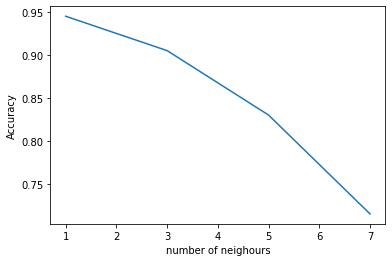

[0.945, 0.905, 0.83, 0.715]


In [ ]:
accuracies = []
kvalues = [1,3,5,7]
for k in kvalues:
  accuracy = KNN_classifier(xtrainp,y_training,xtestp,y_testing,k)
  accuracies.append(accuracy) 
plt.plot(np.array(kvalues),np.array(accuracies))
plt.xlabel("number of neighours")
plt.ylabel("Accuracy")
plt.show()
print(accuracies)


Observation: accuracy decreases by increasing number of neighbours, because large number of neighbours causes underfitting with this data as number of samples per class = 5

### Breaking the Tie:


*   using klearn: breaks the tie by choosing the element that comes firts in the original data
*   choosing randomly between tied classes (not prefferable)

*   decrasing K until the tie breaks
*   increasing K until the tie breaks, may lead to underfitting if k exceeds the number of samples of the tied classes (not prefferable)






Note: for predicting the class of a new point, the new point should be projected first to the same space of traning and testing sets.

### Using another Variant of LDA to improve accuracy: Shrinkage LDA (Bonus)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

estimator = LinearDiscriminantAnalysis(solver = 'eigen',shrinkage='auto')

estimator.fit(x_training, y_training)
xtrainnew = estimator.transform(x_training)
xtestnew = estimator.transform(x_testing)
print(xtrainnew.shape)
print(xtestnew.shape)
print('Accuracy after shrinkage LDA = ' + str(KNN_classifier(xtrainnew,y_training,xtestnew,y_testing,1)))


(200, 39)
(200, 39)
Accuracy after shrinkage LDA = 0.97


Shrinkage linear discriminant analysis (LDA) is a variant of LDA that uses a shrinkage estimator to regularize the covariance matrices of the classes. In normal LDA, the covariance matrices are estimated using the sample covariance of the entire dataset, which can be unstable and lead to overfitting. Shrinkage LDA addresses this issue by using a shrinkage estimator, such as the Ledoit-Wolf estimator, to regularize the covariance matrices and improve their stability, It is observed that there are many features and few number of sample in this problem, Therefore, Regularization will improve the performance

Shrinkage Linear Discriminant Analysis (LDA) improves performance by addressing the issue of high-dimensional data and the curse of dimensionality. In high-dimensional data, the number of variables (features) is often much larger than the number of observations, making it difficult to estimate the parameters of a statistical model accurately.

Traditional LDA assumes that the covariance matrix of each class is equal, which may not hold true in high-dimensional data. Shrinkage LDA overcomes this limitation by introducing a shrinkage parameter that shrinks the sample covariance matrix towards a common covariance matrix. This common covariance matrix is a weighted average of the individual covariance matrices of each class.

By shrinking the covariance matrix towards a common covariance matrix, Shrinkage LDA reduces the estimation error and improves the accuracy of the classification. Moreover, it also prevents overfitting by regularizing the model and stabilizes the covariance matrix estimate. Shrinkage LDA has been shown to outperform traditional LDA in various classification tasks, especially in high-dimensional data with small sample sizes.

# Faces Vs Non-faces

## reading non faces data:

In [ ]:
def get_non_face_data():
  #label = []
  y = np.zeros((600,))
  images = []
  d_shape = (1, 10304)
  data = np.empty(d_shape)
  i = 0
  dir = "/content/drive/MyDrive/pattern/FaceRecognition/non_faces"
  #dir = "./non_faces"
  for img in glob.glob(dir + "/*"):
    if(i == 600):
      break
    image = cv.imread(img,0)
    #row, col = image.shape
    image = image[:92, :112]
    images.append(image)
    image = np.reshape(image,(1,10304))
    data = np.append(data, image, axis = 0)
    #label.append(i)
    i += 1
  data = np.delete(data, (0), axis=0)

  #print(data.shape)
  #y = np.array(label)
  #print(y.shape)
  #print(y)
  return data, y, images

d_non,y_non,images_non = get_non_face_data()    
print(d_non.shape)
print(y_non.shape)

(600, 10304)
(600,)


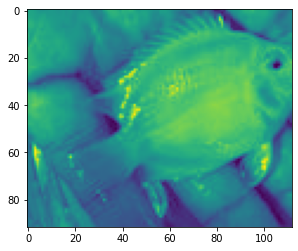

In [ ]:
plt.imshow(images_non[40])

### concatenating faces and non-faces data:

In [ ]:
y_faces = np.ones((400,))

dt = np.concatenate((data, d_non[:400]),axis = 0)
yt = np.concatenate((y_faces, y_non[:400]),axis = 0)
print(yt.shape)

(800,)


### splitting the data into training and testing sets

In [ ]:
# splitting the data 
#--------------
#training set ( odd rows )
#----------------
x_testing_non = dt[1::2,:]
y_testing_non = yt[1::2] 

#--------------
#test set ( even rows )
#----------------
x_training_non = dt[::2,:]
y_training_non = yt[::2]

## applying PCA on new data:

In [ ]:
# using PCA 

alphas = [0.5, 0.75, 0.8, 0.95]
Us, U, shape = pca (x_training_non, alphas)

### getting accuracies with different alphas:

In [ ]:
i = 0
accuracies_non = []
x_training_non_new = []
x_testing_non_new = []
ypredict = []

# looping on all values of alpha to project the data on the corresponding projection matrix and calculate the accuracy
for alpha in alphas:
    # projecting the training set
    x_training_non_new.append(np.dot(x_training_non, Us[i]))
    print(x_training_non_new[i].shape)
    # projecting the test set
    x_testing_non_new.append(np.dot(x_testing_non, Us[i]))
    print(x_testing_non_new[i].shape)
    # calculating accuracy
    accuracy ,yp = KNN_classifier(x_training_non_new[i],y_training_non,x_testing_non_new[i],y_testing_non,1)
    accuracies_non.append(accuracy)
    ypredict.append(yp)
    i = i + 1
print("%.8f" % accuracies_non[0])
print("%.8f" % accuracies_non[1])
print("%.8f" % accuracies_non[2])
print("%.8f" % accuracies_non[3])
#print(accuracies_non)


(400, 4)
(400, 4)
(400, 19)
(400, 19)
(400, 31)
(400, 31)
(400, 149)
(400, 149)
0.98750000
0.99500000
0.99500000
0.99750000


### PCA tuning:

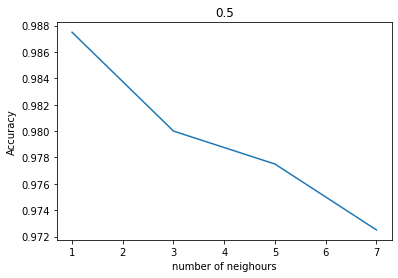

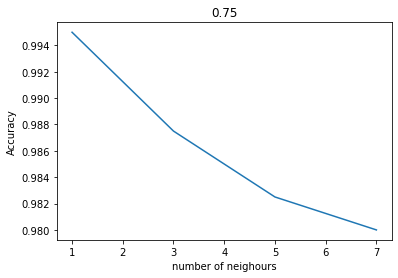

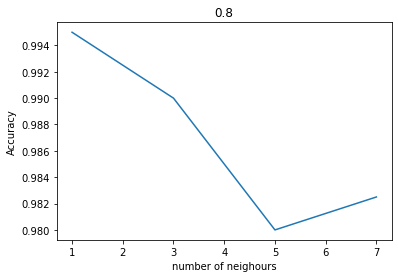

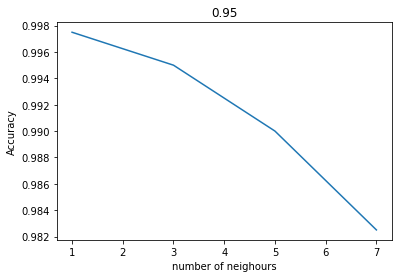

In [ ]:
# PCA tuning to get best number of neighbors:
i = 0
for alpha in alphas:
  accuracies = []
  kvalues = [1,3,5,7]
  for k in kvalues:
    accuracy,yp = KNN_classifier(x_training_non_new[i],y_training_non,x_testing_non_new[i],y_testing_non,k)
    accuracies.append(accuracy) 
  plt.plot(np.array(kvalues),np.array(accuracies))
  plt.title(alpha)
  plt.xlabel("number of neighours")
  plt.ylabel("Accuracy")
  plt.show()
  i = i + 1

### Failure cases after applying PCA:

In [ ]:
y_error = []
for i in range(len(alphas)):
  error = [ids for ids, value in enumerate(ypredict[i] == y_testing_non) if value == False]
  y_error.append(error)

at alpha  = 0.5
predicted value = 0.0
True value = 1.0


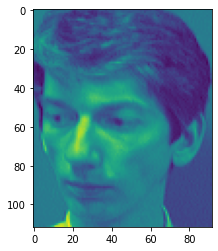

at alpha  = 0.5
predicted value = 1.0
True value = 0.0


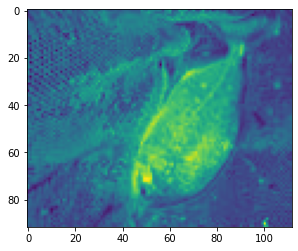

at alpha  = 0.5
predicted value = 1.0
True value = 0.0


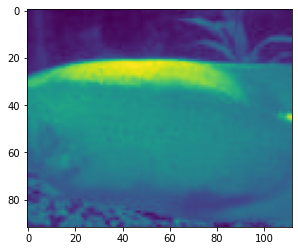

at alpha  = 0.5
predicted value = 1.0
True value = 0.0


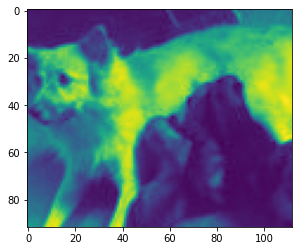

at alpha  = 0.5
predicted value = 1.0
True value = 0.0


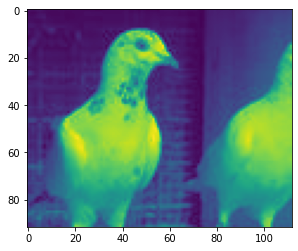

at alpha  = 0.75
predicted value = 1.0
True value = 0.0


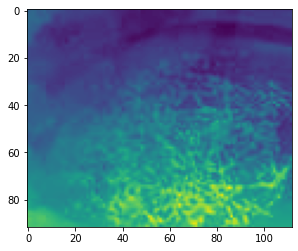

at alpha  = 0.75
predicted value = 1.0
True value = 0.0


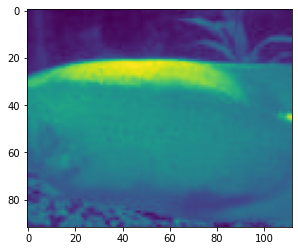

at alpha  = 0.8
predicted value = 1.0
True value = 0.0


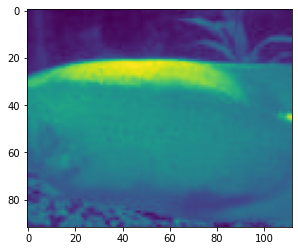

at alpha  = 0.8
predicted value = 1.0
True value = 0.0


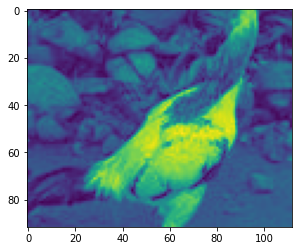

at alpha  = 0.95
predicted value = 1.0
True value = 0.0


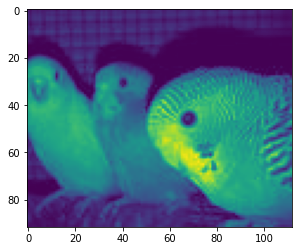

In [ ]:
i = 0
for alpha in alphas:
  for y in y_error[i]:
      print('at alpha  = ' + str(alpha))
      print('predicted value = ' + str(ypredict[i][y]))
      print('True value = ' + str(y_testing_non[y]))
      if y<200:
        y = y*2 + 1
        plt.imshow(images[y])
        plt.show()
      else:
        y -= 200
        y = y*2 + 1
        plt.imshow(images_non[y])
        plt.show()
  i += 1     

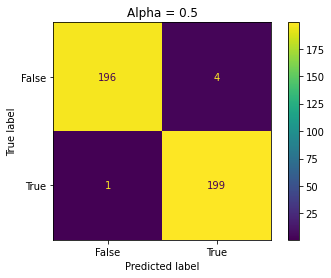

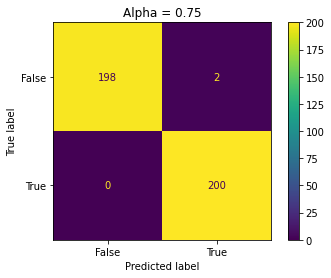

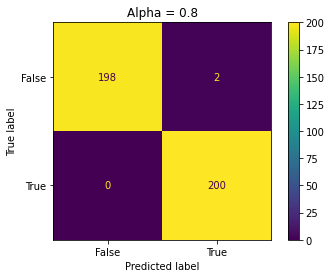

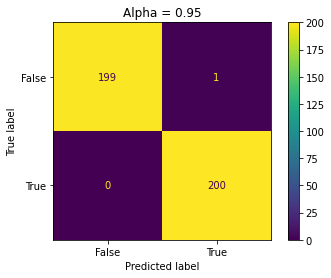

In [ ]:
# confusion matrix to analyze errors

i = 0
for alpha in alphas:
    confusion_matrix = metrics.confusion_matrix(y_testing_non, ypredict[i])

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display.plot()
    plt.title("Alpha = " + str(alpha))
    plt.show()
    i+=1


## applying LDA on new data:

In [ ]:
# using LDA:
u = LDA(x_training_non,2)
xtrainp = project(x_training_non,u)
xtestp = project(x_testing_non,u)
accuracy, ypredict = KNN_classifier(xtrainp,y_training_non,xtestp,y_testing_non,1)
print(accuracy) 

10304
0.945


### LDA tuning:

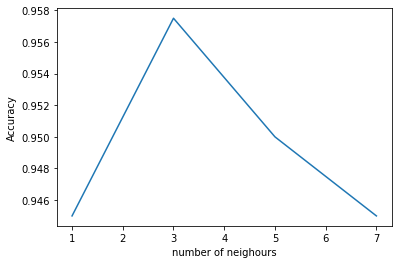

[0.945, 0.9575, 0.95, 0.945]


In [ ]:
#LDA tuning to get best number of neighbours
accuracies = []
kvalues = [1,3,5,7]
for k in kvalues:
    accuracy,yp = KNN_classifier(xtrainp,y_training_non,xtestp,y_testing_non,k)
    accuracies.append(accuracy) 
plt.plot(np.array(kvalues),np.array(accuracies))
# plt.title(alpha)
plt.xlabel("number of neighours")
plt.ylabel("Accuracy")
plt.show()
print(accuracies)

### Observation:
after tuning, the best number of neihbours for LDA is 3 neighbours and PCA is 1 neighbour

### getting failure cases after applying LDA (using best number of neighbours):



predicted value = 0.0
True value = 1.0


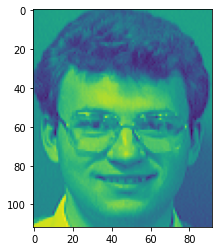

predicted value = 0.0
True value = 1.0


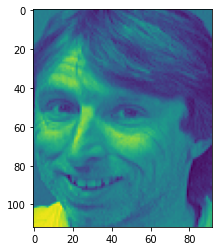

predicted value = 0.0
True value = 1.0


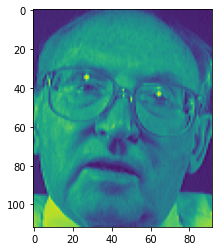

predicted value = 0.0
True value = 1.0


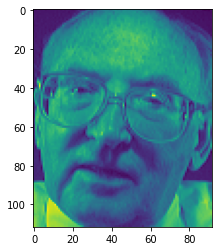

predicted value = 0.0
True value = 1.0


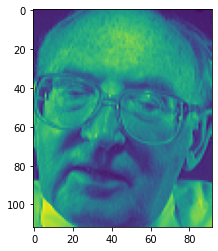

predicted value = 0.0
True value = 1.0


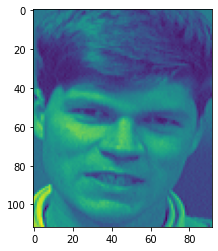

predicted value = 0.0
True value = 1.0


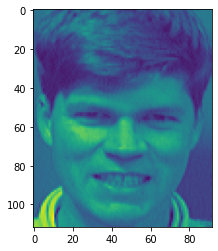

predicted value = 0.0
True value = 1.0


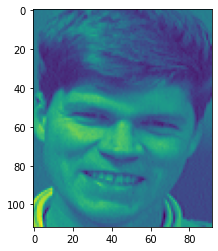

predicted value = 1.0
True value = 0.0


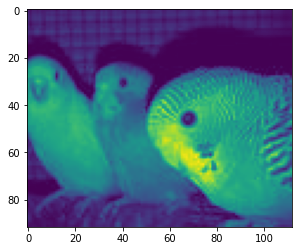

predicted value = 1.0
True value = 0.0


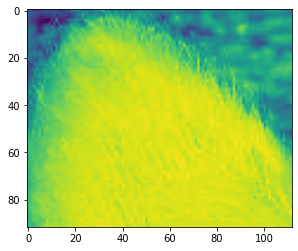

predicted value = 1.0
True value = 0.0


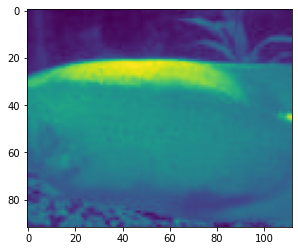

predicted value = 1.0
True value = 0.0


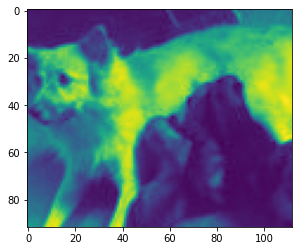

predicted value = 1.0
True value = 0.0


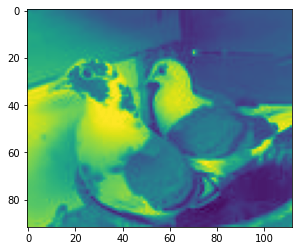

predicted value = 1.0
True value = 0.0


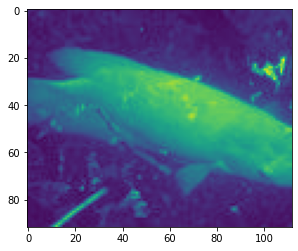

predicted value = 1.0
True value = 0.0


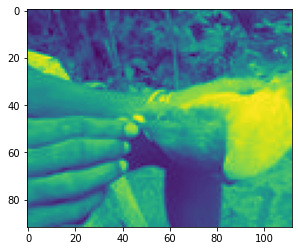

predicted value = 1.0
True value = 0.0


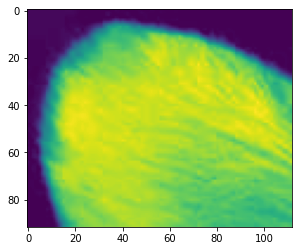

predicted value = 1.0
True value = 0.0


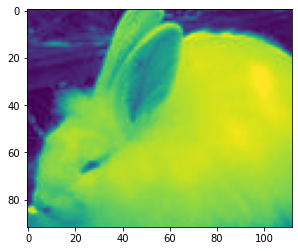

In [ ]:
accuracy,yp = KNN_classifier(xtrainp,y_training_non,xtestp,y_testing_non,3)
accuracies.append(accuracy) 
error = [ids for ids, value in enumerate(yp == y_testing_non) if value == False]
for y in error:
    print('predicted value = ' + str(yp[y]))
    print('True value = ' + str(y_testing_non[y]))
    if y<200:
        y = y*2 + 1
        plt.imshow(images[y])
        plt.show()
    else:
        y -= 200
        y = y*2 + 1
        plt.imshow(images_non[y])
        plt.show()

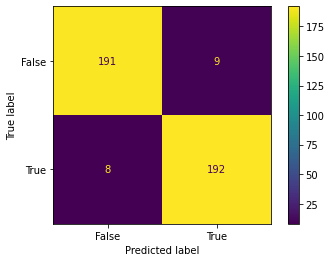

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_testing_non, yp)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

### the number of eigen vectors used in LDA is 1 :

The reason for this is that LDA seeks to project the data onto a lower-dimensional space while preserving the class-discriminatory information as much as possible. The number of components determines the dimensionality of the new space onto which the data is projected. If the number of components is greater than the number of classes minus one, then the projection will be over-determined and may not provide useful discriminative information.

On the other hand, if the number of components is less than the number of classes minus one, then the projection may not be able to capture all of the discriminative information, and some information about the classes may be lost.

Therefore, the number of components in LDA is chosen based on the balance between the dimensionality of the new space and the amount of discriminative information that needs to be preserved.





## measuring accuracies after using different number of non-faces samples and fixing number of faces samples:

In [ ]:
# fixing alpha = 0.8
nums = [200, 400, 600]
i = 0
accuracies_pca = []
ypredict_pca = []

accuracies_lda = []
ypredict_lda = []
for num in nums:
  y_faces = np.ones((400,))
  y = np.zeros((num,))
  dt = np.concatenate((data, d_non[:num]),axis = 0)
  yt = np.concatenate((y_faces, y_non[:num]),axis = 0)
  print(yt.shape)
  # splitting the data 
  #--------------
  #training set ( odd rows )
  #----------------
  x_testing_non = dt[1::2,:]
  y_testing_non = yt[1::2] 

  #--------------
  #test set ( even rows )
  #----------------
  x_training_non = dt[::2,:]
  y_training_non = yt[::2]

  Us, U, shape = pca (x_training_non, [0.8])
  x_training_non_new = np.dot(x_training_non, Us[0])
  x_testing_non_new = np.dot(x_testing_non, Us[0])
  accuracy_pca ,yp_pca = KNN_classifier(x_training_non_new,y_training_non,x_testing_non_new,y_testing_non,1)
  accuracies_pca.append(accuracy_pca)
  ypredict_pca.append(yp_pca)
  

  u = LDA(x_training_non,2)
  x_training_non_new = np.dot(x_training_non, u)
  x_testing_non_new = np.dot(x_testing_non, u)
  
  accuracy_lda ,yp_lda = KNN_classifier(x_training_non_new,y_training_non,x_testing_non_new,y_testing_non,1)
  accuracies_lda.append(accuracy_lda)
  ypredict_lda.append(yp_lda)
  i = i + 1


(600,)
[97.49333333 97.03666667 98.09333333 ... 90.44       90.17
 88.69333333]
[[ 25.50666667  23.96333333  27.90666667 ... -50.44       -55.17
  -46.69333333]
 [ 30.50666667  27.96333333  26.90666667 ...  -5.44        -0.17
   -4.69333333]
 [ 31.50666667  29.96333333  34.90666667 ...   2.56         2.83
    4.30666667]
 ...
 [104.50666667 104.96333333 104.90666667 ... -23.44       -22.17
  -19.69333333]
 [ 16.50666667  15.96333333  14.90666667 ...  70.56        68.83
   53.30666667]
 [153.50666667 153.96333333 152.90666667 ... 162.56       162.83
  164.30666667]]
[ 7.79503309e+06  3.04904260e+06  2.10156237e+06 ... -2.56698652e-09
 -3.08188036e-09 -4.28079935e-09]
[[-0.00874139  0.01417116  0.00536378 ...  0.          0.
   0.        ]
 [-0.00911497  0.01419121  0.00543257 ... -0.04543526  0.08381474
  -0.44435167]
 [-0.00913068  0.01476814  0.00584203 ...  0.00801737 -0.28401534
   0.39497352]
 ...
 [-0.00093491  0.01846     0.00276428 ... -0.00334772  0.00533131
  -0.00824629]
 [-0

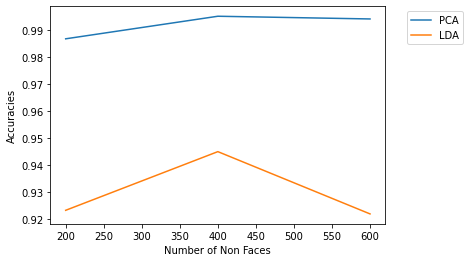

PCA accuricies[0.9866666666666667, 0.995, 0.994]
LDA accuricies[0.9233333333333333, 0.945, 0.922]


In [ ]:
plt.xlabel("Number of Non Faces")
plt.ylabel("Accuracies")

plt.plot(np.array(nums),np.array(accuracies_pca), label="PCA")
plt.plot(np.array(nums),np.array(accuracies_lda), label="LDA")

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.show()
print('PCA accuricies' + str(accuracies_pca))
print('LDA accuricies' + str(accuracies_lda))

Observation : increasing the number of non faces images while fixing the number of faces images, leads to imbalancing between the number of samples in each class, and this leads the algorithm to be biased towards the majority class, which will reduce its performance.

# BONUS

## splitting the data

In [ ]:
d_bonus_train = np.empty((1, 10304))
d_bonus_test = np.empty((1, 10304))
y_bonus_train = []
y_bonus_test = []
for i in range(400):
  stri = str(i)
  if stri[-1] == '7' or stri[-1] == '8' or stri[-1] == '9':
    d_bonus_test = np.append(d_bonus_test , data[[i]] , axis=0)
    # y_bonus_test = 
    y_bonus_test.append(y[i])
  else:
    d_bonus_train = np.append(d_bonus_train , data[[i]] , axis=0)
    #y_bonus_train = 
    y_bonus_train.append(y[i]) 

d_bonus_train = d_bonus_train[1:,]   
d_bonus_test = d_bonus_test[1:,]  

print(d_bonus_train.shape)
print(len(y_bonus_train))

print(d_bonus_test.shape)
print(len(y_bonus_test))


(280, 10304)
280
(120, 10304)
120


## PCA

In [ ]:
alphas = [0.8, 0.85, 0.9, 0.95]
Us_bonus, U_bonus, shape_bonus = pca (d_bonus_train, alphas)
print ( shape_bonus)

[85.34285714 85.16071429 85.63928571 ... 75.88928571 76.05714286
 75.87142857]
[[ 37.65714286  35.83928571  40.36071429 ... -35.88928571 -41.05714286
  -33.87142857]
 [ 45.65714286  39.83928571  40.36071429 ...  13.11071429  16.94285714
   15.12857143]
 [ 42.65714286  39.83928571  39.36071429 ...   9.11071429  13.94285714
    8.12857143]
 ...
 [-41.34285714 -37.16071429 -40.63928571 ... -42.88928571 -40.05714286
  -38.87142857]
 [-40.34285714 -36.16071429 -38.63928571 ... -35.88928571 -46.05714286
  -31.87142857]
 [-34.34285714 -37.16071429 -42.63928571 ... -46.88928571 -48.05714286
  -43.87142857]]
[ 2.76363382e+06  2.10892541e+06  1.08569347e+06 ... -1.52162455e-09
 -1.56457245e-09 -1.76904090e-09]
[[ 1.77203567e-03 -1.53353904e-02 -1.82067010e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.69037804e-03 -1.53683147e-02 -1.82128722e-02 ...  7.09057989e-02
  -5.07624008e-01  1.86254426e-01]
 [ 1.88260764e-03 -1.53142586e-02 -1.81215290e-02 ... -4.39000570e-01
   8.71655

In [ ]:
# printing the original accuracy before projection
accuracy, y_predict_bonus = KNN_classifier(d_bonus_train,y_bonus_train,d_bonus_test,y_bonus_test,1)
print("original accuracy before projection:", accuracy)

original accuracy before projection: 0.9666666666666667


In [ ]:
i = 0
accuracies = []
x_training_new = []
x_testing_new = []

# looping on all values of alpha to project the data on the corresponding projection matrix and calculate the accuracy
for alpha in alphas:
    # projecting the training set
    x_training_new.append(np.dot(d_bonus_train, Us_bonus[i]))
    print(x_training_new[i].shape)
    # projecting the test set
    x_testing_new.append(np.dot(d_bonus_test, Us_bonus[i]))
    print(x_testing_new[i].shape)
    # calculating accuracy
    accuracy, y_predict_bonus = KNN_classifier(x_training_new[i],y_bonus_train,x_testing_new[i],y_bonus_test,1)
    accuracies.append(accuracy)
    i = i + 1
print(accuracies)


(280, 40)
(120, 40)
(280, 59)
(120, 59)
(280, 91)
(120, 91)
(280, 147)
(120, 147)
[0.9916666666666667, 0.9833333333333333, 0.9666666666666667, 0.9666666666666667]


Text(0, 0.5, 'accuracy')

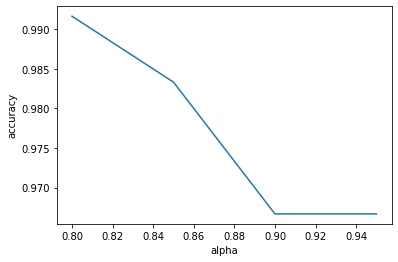

In [ ]:
# plotting each alpha against its accuracy
plt.plot(alphas, accuracies)
plt.xlabel('alpha')
plt.ylabel('accuracy')

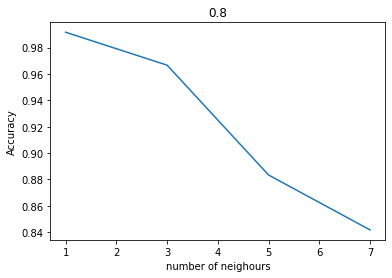

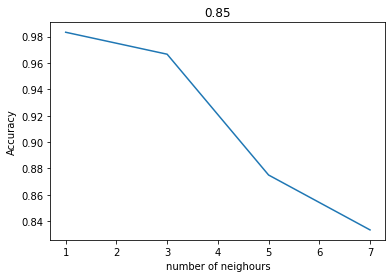

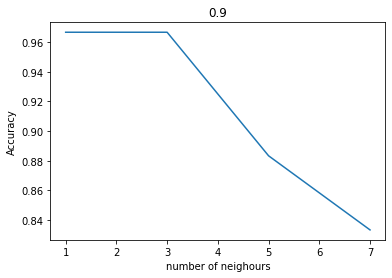

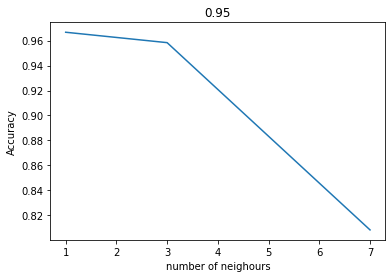

In [ ]:
i = 0
for alpha in alphas:
  accuracies = []
  kvalues = [1,3,5,7]
  for k in kvalues:
    accuracy,ypredict = KNN_classifier(x_training_new[i],y_bonus_train,x_testing_new[i],y_bonus_test,k)
    accuracies.append(accuracy) 
  plt.plot(np.array(kvalues),np.array(accuracies))
  plt.title(alpha)
  plt.xlabel("number of neighours")
  plt.ylabel("Accuracy")
  plt.show()
  i = i + 1

## LDA

In [ ]:
u = LDA(d_bonus_train,40)
xtrainp = project(d_bonus_train,u)
xtestp = project(d_bonus_test,u)
accuracy, ypredict = KNN_classifier(xtrainp,y_bonus_train,xtestp,y_bonus_test,1)
print(accuracy) 

10304
0.975


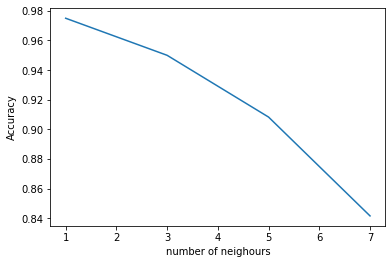

[0.975, 0.95, 0.9083333333333333, 0.8416666666666667]


In [ ]:
accuracies = []
kvalues = [1,3,5,7]
for k in kvalues:
    accuracy,yp = KNN_classifier(xtrainp,y_bonus_train,xtestp,y_bonus_test,k)
    accuracies.append(accuracy) 
plt.plot(np.array(kvalues),np.array(accuracies))
# plt.title(alpha)
plt.xlabel("number of neighours")
plt.ylabel("Accuracy")
plt.show()
print(accuracies)